In [21]:
import torch 
import matplotlib.pyplot as plt
from fmfts.experiments.ns2d.models import VelocityModelNS2D
from fmfts.experiments.ns2d.models import FlowModelNS2D
from fmfts.dataloader.ns2d import DatasetNS2D

torch.set_grad_enabled(False)
torch.set_default_device("cuda")

velocity = VelocityModelNS2D(features = (64, 96, 96, 128))
velocity.load_state_dict(torch.load("trained_models/model_velocity.pt", weights_only=True))
flow = FlowModelNS2D(velocity_model = velocity, features = (64, 96, 96, 128))
flow.load_state_dict(torch.load("trained_models/model_flow.pt", weights_only=True))
dataset_test = DatasetNS2D(mode = "test")

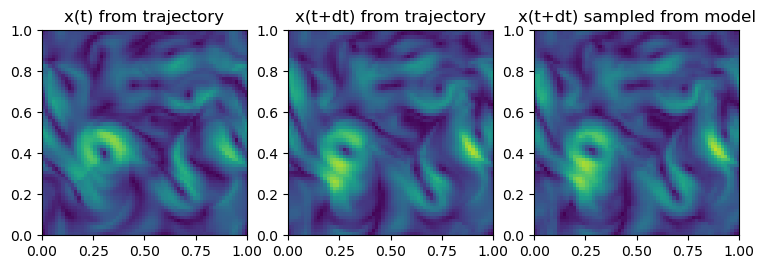

In [22]:
# demonstrates how one can predict a single sample
y = dataset_test.get(0, 0, sequence_len=1)
x = dataset_test.get(0, 1, sequence_len=1)
x_pred = velocity.sample(y, steps=10, method="midpoint")

# plotting
fig, ax = plt.subplots(1, 3, figsize=(3*3, 3))
dataset_test.plot(y, ax[0])
dataset_test.plot(x, ax[1])
dataset_test.plot(x_pred, ax[2])
ax[0].set_title("x(t) from trajectory")
ax[1].set_title("x(t+dt) from trajectory")
ax[2].set_title("x(t+dt) sampled from model")
plt.show()

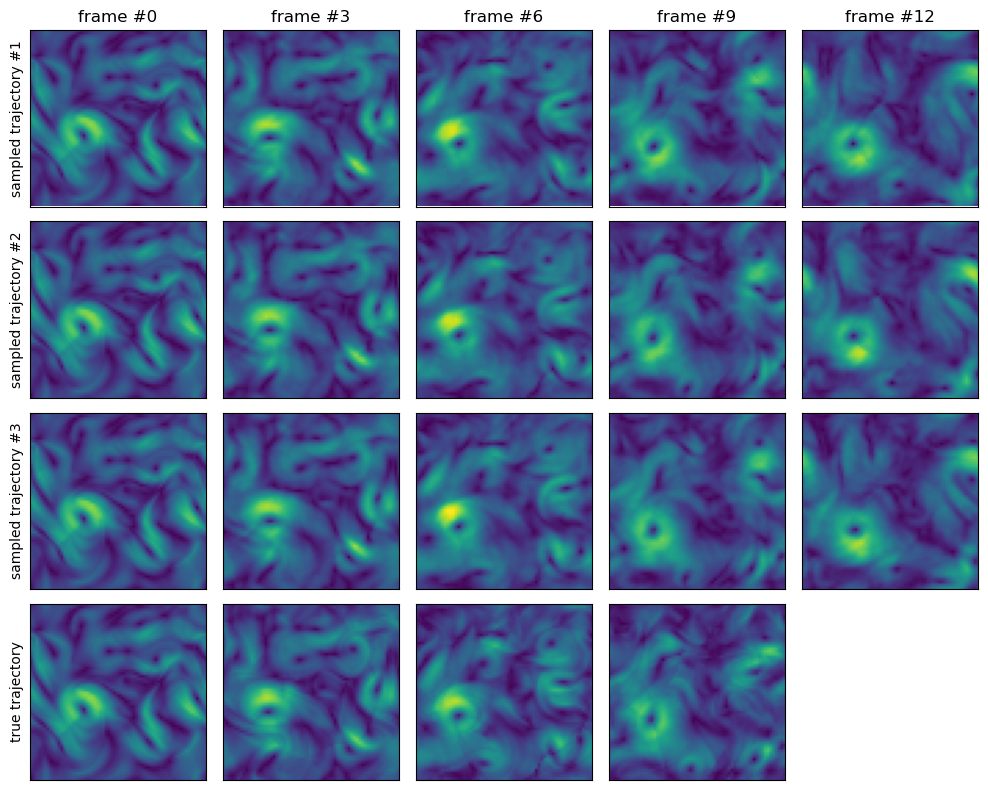

In [25]:
# demonstrates how one can generate multiple trajectories
n_trajectories = 3
n_predictions = 15
y = dataset_test.get(0, 0, sequence_len=10)

xs = torch.empty(n_predictions, n_trajectories, *y.shape[1:])
xs[0,:] = y[0].clone()
for k in range(n_predictions-1):
    # xs[k+1] = velocity.sample(xs[k], steps=5, method="midpoint") 
    xs[k+1] = flow.sample(xs[k], steps=1)

# plotting
n_plots   = 5

fig, ax = plt.subplots(n_trajectories + 1, n_plots, figsize=(n_plots*2, (n_trajectories+1)*2))
for k in range(n_trajectories):
    for i in range(n_plots):
        l = i * n_predictions // n_plots
        dataset_test.plot(xs[l, k], ax[k, i])
        ax[k, i].set_xticks([])
        ax[k, i].set_yticks([])
    ax[k,0].set_ylabel(f"sampled trajectory #{k+1}")

for i in range(n_plots):
    l = i * n_predictions // n_plots
    if l < len(y): 
        dataset_test.plot(y[l], ax[-1, i])
        ax[-1, i].set_xticks([])
        ax[-1, i].set_yticks([])
    else:                          
        ax[-1, i].remove()

    ax[0, i].set_title(f"frame #{l}")
ax[-1, 0].set_ylabel("true trajectory")

plt.tight_layout()
plt.show()

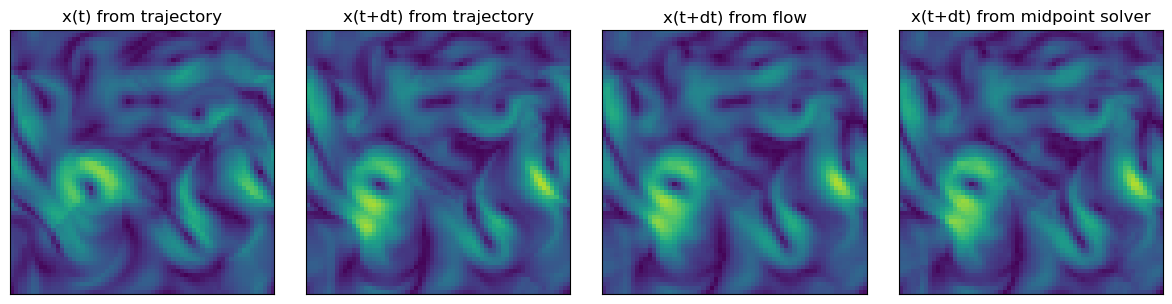

In [24]:
# demonstrates how one can predict a single sample
y = dataset_test.get(0, 0, sequence_len=1)
x = dataset_test.get(0, 1, sequence_len=1)
x0 = flow.p0.sample(y.shape).to("cuda")
x_pred_f = flow.sample(y, steps=1, x0=x0)
x_pred_v = flow.v.sample(y, steps=20, x0=x0, method="midpoint")

fig, ax = plt.subplots(1, 4, figsize=(3*4, 3))
dataset_test.plot(y, ax[0])
dataset_test.plot(x, ax[1])
dataset_test.plot(x_pred_f, ax[2])
dataset_test.plot(x_pred_v, ax[3])
ax[0].set_title("x(t) from trajectory")
ax[1].set_title("x(t+dt) from trajectory")
ax[2].set_title("x(t+dt) from flow")
ax[3].set_title("x(t+dt) from midpoint solver")
for i in range(4): 
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.tight_layout()
plt.show()